In [29]:
import os, sys, time           
import numpy as np             
import matplotlib.pyplot as plt
%matplotlib inline               
import math

# input parameters

def massrateproduct(alpha):
    R_in = 1.0    # inner edge of CPD in Rjup units
    R_out = 1.85  # outer edge of CPD in AU
    R_p = 1.0     # planet radius in Rjup units
    M_p =1 # planet mass in Mjup
    Mdot=np.logspace(-8,-1, 1000)# planetary accretion rate in Mjup / yr
    # turbulence coefficient (dimension-less)
    wl = 0.85     # wavelength in mm
    dpc = 140.    # distance in pc


    # constants (cgs units)
    G = 6.67e-8        # cm**2 / g / s**2
    kB = 1.3801e-16    # erg / K
    sigSB = 5.67e-5    # erg / cm**2 / s / K**4
    mu = 2.4           # 1 / mol
    Rg = 8.3145e7      # erg / K / mol
    AU = 1.496e13      # cm
    Msun = 1.989e33    # g
    Mjup = 1.898e30    # g
    Rjup = 6.9911e9    # cm
    yr = 3.154e7       # s
    iflux=np.zeros(len(Mdot))
    # radius grid
    for i in range(len(Mdot)):
        Rau = np.logspace(np.log10(R_in * Rjup / AU), 0.5, 1000)
        R = Rau * AU

        # opacities
        kappa_mm = 0.034 * (0.87 / wl)
        kappa_r = 10.                      

        # Eq 1: effective temperature: Teff**4 (K**4)
        Teff4 = 3 * G * (M_p * Mjup) * (Mdot[i] * Mjup / yr) * (1 - (R[0] / R)**0.5) / (8 * np.pi * sigSB * R**3)
        Teff4 = np.clip(Teff4, 5**4, 10000**4)

        # Eq 3: irradiation temperature
        Lirr = G * (M_p * Mjup) * (Mdot[i] * Mjup / yr) / (2 * R_p * Rjup)
        Tirr4 = Lirr / (40 * np.pi * R**2 * sigSB)

        # external temperature
        Tism = 10.
        Text4 = Tirr4 + Tism**4

        # Eq 6: sigma
        sig_eq6 = (2**1.4 / 3**1.2) * (sigSB * G * (M_p * Mjup) * (Mdot[i] * Mjup / yr)**3 / \
                  (alpha**4 * np.pi**3 * kappa_r * R**3))**0.2 * (mu / Rg)**0.8 *(1 - (R[0] / R)**0.5)**0.6

        # Eq 7: sigma
        omega = np.sqrt(G * (M_p * Mjup) / R**3)
        sig_eq7 = (Mdot[i] * Mjup / yr) * mu * omega / (3 * np.pi * alpha * Rg * Text4**0.25)

        # sigma (note that Fig 1 is for viscous heating models, which means Eq 6 for sigma [see caption])
        #sigma = np.minimum(sig_eq6, sig_eq7)
        sigma = sig_eq6

        # Eq 4: midplane temperature: Tc**4
        Tc4 = 9 * G * (M_p * Mjup) * (Mdot[i] * Mjup / yr) * sigma * kappa_r * (1 - (R[0] / R)**0.5) / \
              (128 * np.pi * sigSB * R**3) + Text4


        # mm optical depths
        tau_mm = kappa_mm * sigma / 2

        # Eq 8: brightness temperatures
        Tb = ((3 * kappa_r / (8 * kappa_mm)) * Teff4 + Text4)**0.25
        Tb[tau_mm < 0.5] = 2 * Tc4[tau_mm < 0.5]**0.25 * tau_mm[tau_mm < 0.5]
        Inu = 1e23 * 2 * kB * Tb / (wl * 0.1)**2 / (180 * 3600 / np.pi)**2



        iflux[i] = (np.trapz(2 * np.pi *R * Inu, R))/(math.pi*R[-1]**2)
        
    return iflux, M_p*Mdot


###function calculates the average flux over the disk based on an alpha value input. 
##Returns a list of flux values and a list of mass-accretion rate products####

Text(0, 0.5, 'Average CPD flux (Jy/$arsec^2$)')

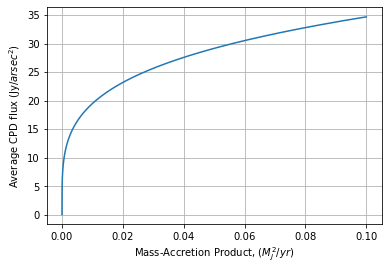

In [30]:
z=massrateproduct(0.001)


###Plot of average fluxes against Mass-Accretion Products###
fig, axs = plt.subplots()
axs.plot(z[1], z[0])
axs.grid()
axs.set_xlabel('Mass-Accretion Product, ($M^2_{J}/yr$)')
axs.set_ylabel('Average CPD flux (Jy/$arsec^2$)')
